In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import os
import cv2 as cv
import imghdr

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Dense , Flatten , Dropout , AveragePooling2D

from tensorflow.keras.metrics import Precision , Recall , BinaryAccuracy

from tensorflow.keras.models import load_model

In [24]:
plt.style.use("ggplot")

In [4]:
LeNet = Sequential()
LeNet.add(Conv2D(6 , (5,5) , activation = "sigmoid" , input_shape = (32 , 32 , 3) ))
LeNet.add(AveragePooling2D( pool_size = (2,2) )) # pool matrix size = 2

LeNet.add(Conv2D(16 , (5,5) , activation = "sigmoid"  ))
LeNet.add(AveragePooling2D( pool_size = (2,2) ))

LeNet.add(Flatten())

LeNet.add(Dense(120 , activation = "sigmoid"))
LeNet.add(Dense(84 , activation = "sigmoid"))

LeNet.add(Dense(5 , activation = "softmax"))

LeNet.compile(optimizer = "adam" , loss = tf.losses.SparseCategoricalCrossentropy() , metrics = ["accuracy"])

In [5]:
LeNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         456       
                                                                 
 average_pooling2d (Average  (None, 14, 14, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 5, 5, 16)          0         
 gePooling2D)                                                    
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 120)               4

In [6]:
# Creating pipeline

data_dir = "data"
os.listdir(data_dir)

['ballerina cappuccina',
 'brr brr patapim',
 'lirili larila',
 'tralalero tralala',
 'tung tung tung sahur']

In [7]:
valid = ["jpeg" , "jpg" , "bmp" , "png"]
for image_class in os.listdir(data_dir) :
    for image in os.listdir(os.path.join(data_dir , image_class)) :
        image_path = os.path.join(data_dir , image_class , image)
        try :
            img = cv.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in valid :
                os.remove(image_path)
        except Exception as e :
            continue

In [8]:
data = tf.keras.utils.image_dataset_from_directory("data") 

Found 550 files belonging to 5 classes.


In [9]:
data_iterator = data.as_numpy_iterator() 

In [10]:
batch = data_iterator.next() 

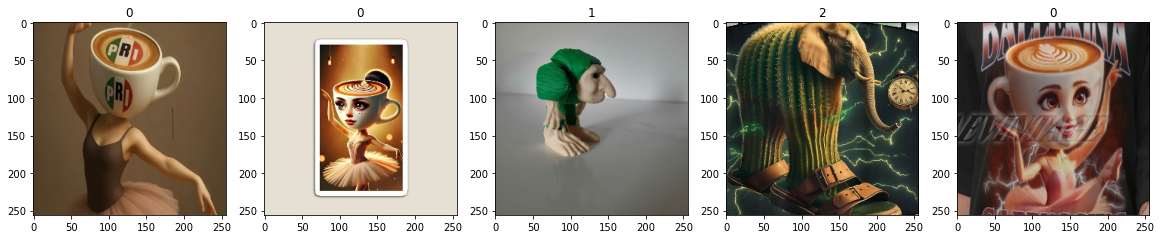

In [11]:
fig , ax = plt.subplots(ncols = 5 , figsize = (20,20))
for idx , img in enumerate(batch[0][:5]) :  
    ax[idx].imshow(img.astype("uint8"))
    ax[idx].title.set_text(batch[1][idx])

In [12]:
scaled = data.map(lambda x, y: (tf.image.resize(x, [32, 32]) / 255.0, y)) 

scaled_iterator = scaled.as_numpy_iterator()

train_size = int(len(scaled) * 0.7)
test_size = int(len(scaled) * 0.1) + 1
val_size = int(len(scaled) * 0.2) + 1

train = scaled.take(train_size)
test = scaled.skip(train_size).take(test_size)
val = scaled.skip(train_size + test_size).take(val_size)

In [13]:
logdir = "logs_LeNet"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [14]:
hist = LeNet.fit(train , epochs = 20 , validation_data = val , callbacks = [tensorboard_callback])

Epoch 1/20
12/12 [==============================] - 11s 557ms/step - loss: 1.7808 - accuracy: 0.1953 - val_loss: 1.6555 - val_accuracy: 0.2059
Epoch 2/20
12/12 [==============================] - 8s 490ms/step - loss: 1.6346 - accuracy: 0.2240 - val_loss: 1.6046 - val_accuracy: 0.2745
Epoch 3/20
12/12 [==============================] - 7s 444ms/step - loss: 1.6123 - accuracy: 0.2396 - val_loss: 1.6064 - val_accuracy: 0.2353
Epoch 4/20
12/12 [==============================] - 7s 449ms/step - loss: 1.6132 - accuracy: 0.2188 - val_loss: 1.6187 - val_accuracy: 0.1765
Epoch 5/20
12/12 [==============================] - 7s 452ms/step - loss: 1.5994 - accuracy: 0.2500 - val_loss: 1.6017 - val_accuracy: 0.2647
Epoch 6/20
12/12 [==============================] - 7s 442ms/step - loss: 1.6040 - accuracy: 0.2474 - val_loss: 1.5920 - val_accuracy: 0.2549
Epoch 7/20
12/12 [==============================] - 7s 447ms/step - loss: 1.6021 - accuracy: 0.2240 - val_loss: 1.5932 - val_accuracy: 0.2451
Epoch

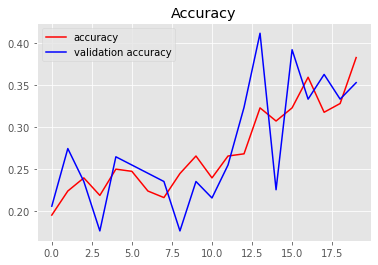

In [25]:
plt.plot(hist.history["accuracy"] , color = "red" , label = "accuracy")
plt.plot(hist.history["val_accuracy"] , color = "blue" , label = "validation accuracy")
plt.title("Accuracy")
plt.legend(loc = "upper left")
plt.show()

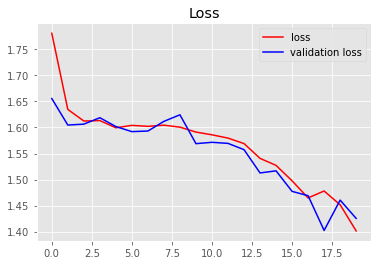

In [26]:
plt.plot(hist.history["loss"] , color = "red" , label = "loss")
plt.plot(hist.history["val_loss"] , color = "blue" , label = "validation loss")
plt.title("Loss")
plt.legend(loc = "upper right")
plt.show()

In [17]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [18]:
for batch in test.as_numpy_iterator():
    x, y = batch
    
    yhat = LeNet.predict(x)

    y_pred = tf.argmax(yhat, axis=1, output_type=tf.int64)

    y_true = tf.convert_to_tensor(y, dtype=tf.int64)

    # Update metrics
    pre.update_state(y_true, y_pred)
    re.update_state(y_true, y_pred)
    acc.update_state(y_true, y_pred)

1/1 [==============================] - 0s 79ms/step


In [19]:
print(f"Precision : {pre.result()} , Recall : {re.result()} , Accuracy : {acc.result()}")

Precision : 0.9285714030265808 , Recall : 0.6842105388641357 , Accuracy : 0.15625


[]

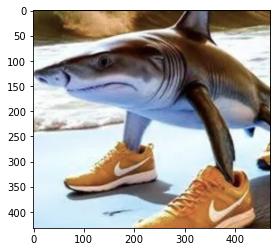

In [20]:
img = cv.imread("tralalero_test.png")
plt.imshow(img)
plt.plot()

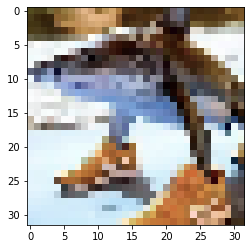

In [21]:
resize = tf.image.resize(img , (32,32))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [22]:
yhat = LeNet.predict(np.expand_dims(resize/255 , 0))
ans = list(yhat[0]).index(max(list(yhat[0])))
if(ans == 0) :
    print("Ballerina Cappucina")
elif (ans == 1) :
    print("Brr Brr Patapim")
elif (ans == 2) :
    print("Lirilla Larila")
elif (ans == 3) :
    print("Tralalero Tralala")
elif (ans == 4) :
    print("Tung Tung Tung Tung Tung Tung Tung Sahur")

1/1 [==============================] - 0s 127ms/step
Ballerina Cappucina


In [23]:
LeNet.save(os.path.join("models" , "breinrot_classifier_LeNet.keras"))